# Limits of Diversification

Why doesnt diversification help you in market crashes?

One reason is that correlations across assets increases as the market drops. Let's see if we can see this in the data.

Let's load up the industry data that we've used in the past.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import edhec_risk_kit_118 as erk

ind_return = erk.get_ind_returns()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Implementing a Cap-Weighted Portfolio

Most market indices are constructed by taking a set of assets and weighting them by their market equity aka market capitalization.

Let's construct a market cap weighted index from our 30 industry portfolios.

For each of these industries, we also have data on the number of stocks in each industry as well as the average market cap in each industry. Thus, we can multiply the average market cap by the number of companies to get the total market capitalization of each industry. We can then weight each industry portfolio proportional to the market capitalization of that industry.

Let's load the industry size and average number of firms:

```python
def get_ind_nfirms():
    """
    Load and format the Ken French 30 Industry Portfolios Average number of Firms
    """
    ind = pd.read_csv("data/ind30_m_nfirms.csv", header=0, index_col=0)
    ind.index = pd.to_datetime(ind.index, format="%Y%m").to_period('M')
    ind.columns = ind.columns.str.strip()
    return ind

def get_ind_size():
    """
    Load and format the Ken French 30 Industry Portfolios Average size (market cap)
    """
    ind = pd.read_csv("data/ind30_m_size.csv", header=0, index_col=0)
    ind.index = pd.to_datetime(ind.index, format="%Y%m").to_period('M')
    ind.columns = ind.columns.str.strip()
    return ind
```

We can clearly refactor the code to be less repetitive, but for now, this will do fine:

In [2]:
import pandas as pd

def get_ind_nfirms():
    """
    Load and format the Ken French 30 Industry Portfolios Average number of Firms
    """
    ind = pd.read_csv("data/ind30_m_nfirms.csv", header=0, index_col=0)
    ind.index = pd.to_datetime(ind.index, format="%Y%m").to_period('M')
    ind.columns = ind.columns.str.strip()
    return ind

def get_ind_size():
    """
    Load and format the Ken French 30 Industry Portfolios Average size (market cap)
    """
    ind = pd.read_csv("data/ind30_m_size.csv", header=0, index_col=0)
    ind.index = pd.to_datetime(ind.index, format="%Y%m").to_period('M')
    ind.columns = ind.columns.str.strip()
    return ind

ind_nfirms = get_ind_nfirms()
ind_size = get_ind_size()


In [3]:
ind_nfirms.head()

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,Cnstr,Steel,FabPr,ElcEq,Autos,Carry,Mines,Coal,Oil,Util,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
1926-07,43,3,16,7,2,8,12,7,17,13,14,45,19,11,39,13,14,8,43,21,5,3,7,6,74,2,33,6,12,4
1926-08,43,3,16,7,2,8,12,7,17,13,14,45,19,11,39,13,14,8,43,21,5,3,7,6,74,2,33,6,12,4
1926-09,43,3,16,7,2,8,12,7,17,13,14,45,19,11,39,13,14,8,42,21,5,3,7,6,74,2,33,6,12,4
1926-10,43,3,16,7,2,8,12,7,17,13,14,45,19,11,39,13,14,8,42,21,5,3,7,6,74,2,33,6,12,4
1926-11,43,3,16,7,2,8,12,7,17,13,14,45,19,11,39,13,14,8,42,21,5,3,7,6,74,2,33,6,12,4


In [4]:
ind_size.head()

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,Cnstr,Steel,FabPr,ElcEq,Autos,Carry,Mines,Coal,Oil,Util,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
1926-07,35.98,7.12,59.72,26.41,12.02,22.27,18.36,25.52,57.59,6.18,20.05,48.56,27.47,110.78,47.55,41.30,27.74,40.52,92.79,81.22,350.36,13.60,56.70,35.35,66.91,1.19,46.65,10.82,18.83,24.25
1926-08,36.10,6.75,60.47,27.17,13.33,22.13,19.83,25.80,62.13,6.20,20.46,50.39,28.91,114.29,55.11,41.50,29.30,40.83,91.43,86.81,353.27,14.75,57.74,37.86,67.99,0.90,46.57,11.00,18.88,25.51
1926-09,37.00,8.58,64.03,27.30,14.67,21.18,19.29,26.73,65.53,6.71,21.41,51.21,29.34,116.69,57.11,42.17,29.45,41.18,94.86,85.01,360.96,15.05,59.61,36.82,71.02,0.95,46.11,10.94,19.67,27.21
1926-10,37.14,8.92,64.42,28.76,14.42,21.23,19.03,26.87,68.47,6.82,21.10,51.02,29.30,114.93,59.69,43.05,29.46,41.30,90.87,86.41,364.16,15.30,59.52,34.77,70.83,0.88,46.15,10.80,19.36,26.16
1926-11,35.88,8.62,65.08,27.38,15.79,20.14,19.03,26.54,65.06,6.84,20.12,48.90,29.60,108.33,54.81,40.44,28.51,41.90,89.87,83.92,363.74,14.89,58.74,32.80,68.75,0.74,45.03,10.33,18.35,23.94


In [5]:
ind_return.shape

(1110, 30)

In [6]:
ind_size.shape

(1110, 30)

In [7]:
ind_nfirms.shape

(1110, 30)

In [5]:
ind_mktcap = ind_nfirms * ind_size

In [9]:
ind_mktcap.shape

(1110, 30)

Now that we have the market caps for each month, we can compute the total market capitalization over time by summing over all industries:

In [6]:
total_mktcap = ind_mktcap.sum(axis=1)

<AxesSubplot:>

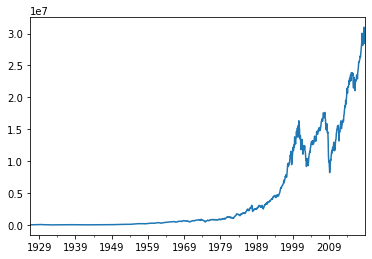

In [7]:
total_mktcap.plot()

Clearly, the market has grown over time. We can now compute the capweight of each industry as follows:

In [8]:
ind_capweight = ind_mktcap.divide(total_mktcap, axis="rows")

Let's verify that the sum of the cap weights of all the columns should always sum to 1.

Because these are floating point numbers, it is not a good idea to test if they sum to 1 by using `== 1.0`. Instead, we make sure they are very close to 1 as follows

In [9]:
all(abs(ind_capweight.sum(axis="columns") - 1) < 1E-10)

True

Let's look at the fraction of the market occupied by the Steel industry over time and compare it with the Finance industry.

<AxesSubplot:>

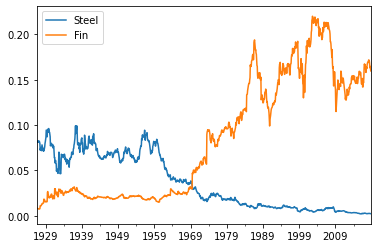

In [10]:
ind_capweight[["Steel", "Fin"]].plot()

# Constructing a Cap Weighted Market Index

One way to construct a market index is to build a portfolio whose weights are rebalanced back to the target weights every period. In reality, the weights may drift over time but this simplification is close enough.

<AxesSubplot:title={'center':'Total Market Cap Weighted Index 1926-2018'}>

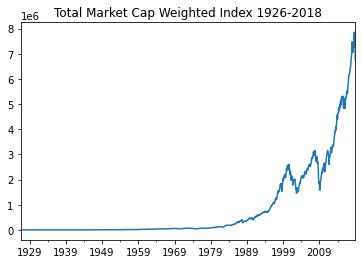

In [11]:
total_market_return = (ind_capweight * ind_return).sum(axis="columns")
total_market_index = erk.drawdown(total_market_return).Wealth
total_market_index.plot(title="Total Market Cap Weighted Index 1926-2018")

Putting it all together we have:

```python
def get_total_market_index_returns():
    """
    Load the 30 industry portfolio data and derive the returns of a capweighted total market index
    """
    ind_nfirms = get_ind_nfirms()
    ind_size = get_ind_size()
    ind_return = get_ind_returns()
    ind_mktcap = ind_nfirms * ind_size
    total_mktcap = ind_mktcap.sum(axis=1)
    ind_capweight = ind_mktcap.divide(total_mktcap, axis="rows")
    total_market_return = (ind_capweight * ind_return).sum(axis="columns")
    return total_market_return
```


<AxesSubplot:title={'center':'Total Market Cap Weighted Index 1926-2018'}>

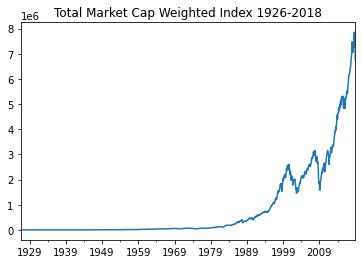

In [12]:
total_market_return = erk.get_total_market_index_returns()
total_market_index = erk.drawdown(total_market_return).Wealth
total_market_index.plot(title="Total Market Cap Weighted Index 1926-2018")

# Rolling Windows

Let's construct a rolling window of returns over a trailing 36 month period. Pandas contains direct support for rolling windows, and allows you to aggregate the returns over a window. In our case, lets compute the average return over a trailing 36 month window.

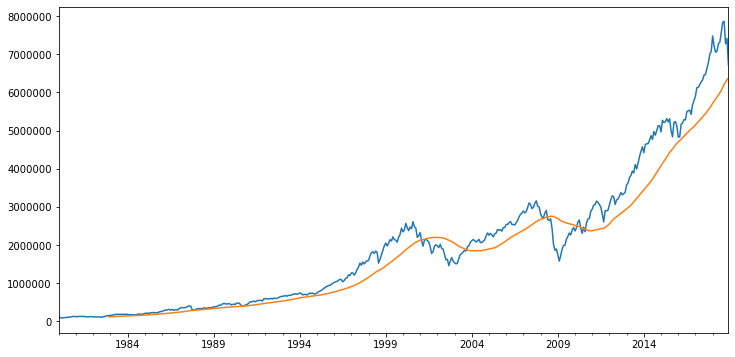

In [15]:
total_market_index["1980":].plot(figsize=(12, 6))
total_market_index["1980":].rolling(window=36).mean().plot()

We dont really want the mean return, we want to look at the trailing 3 year compounded return. We need to apply our own function, instead of `mean()`.

Each time the window is advanced, a new DataFrame (with just the slice of the DataFrame in the window) is used to generate a new value. You can either use one of the built-in DataFrame methods like `.mean` or you can use the `.aggregate` method to apply your own function to each column for all the rows that fall in that window.

Let's create a time series of the annualized returns over the trailing 36 months and the average correlation across stocks over that same 36 months.

<AxesSubplot:>

<AxesSubplot:>

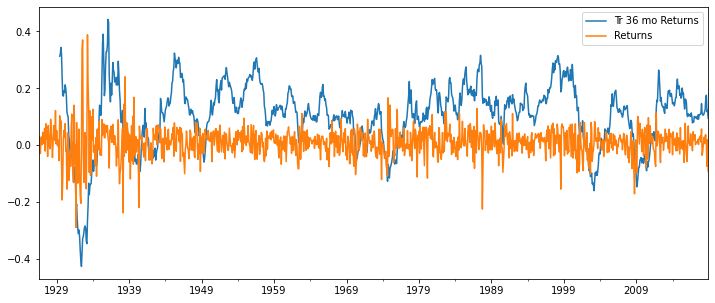

In [13]:
tmi_tr36rets = total_market_return.rolling(window=36).aggregate(erk.annualize_rets, periods_per_year=12)
tmi_tr36rets.plot(figsize=(12,5), label="Tr 36 mo Returns", legend=True)
total_market_return.plot(label="Returns", legend=True)

# Rolling Correlations: Multi Indexes and `.groupby`

Next we want to look at average correlations between all the industries over that same trailing 3 year window.

Let's start by contructing the time series of correlations over time over a 36 month window.

In [14]:
ts_corr = ind_return.rolling(window=36).corr()
ts_corr.tail()

Food      Beer     Smoke     Games     Books     Hshld  \
2018-12 Whlsl  0.474948  0.356983  0.122672  0.510425  0.803362  0.419280   
        Rtail  0.517856  0.406107  0.030283  0.676464  0.636320  0.358336   
        Meals  0.370187  0.385483  0.122007  0.301516  0.520649  0.308216   
        Fin    0.298823  0.192706  0.027593  0.480276  0.694812  0.162690   
        Other  0.436952  0.376565  0.224010  0.331829  0.558072  0.390610   

                  Clths      Hlth     Chems     Txtls     Cnstr     Steel  \
2018-12 Whlsl  0.570071  0.739764  0.785796  0.634197  0.816368  0.699492   
        Rtail  0.676598  0.714933  0.626034  0.634202  0.658994  0.484788   
        Meals  0.302176  0.416193  0.520023  0.491726  0.572513  0.432558   
        Fin    0.425899  0.658468  0.760151  0.577090  0.773804  0.642889   
        Other  0.467099  0.645035  0.712511  0.520953  0.686232  0.656796   

                  FabPr     ElcEq     Autos     Carry     Mines      Coal  \
2018-12 Whlsl  0.765434  0.809080  0.666586  0.647362  0.455265  0.342075   
        Rtail  0.567568  0.624063  0.457879  0.628050  0.233629  0.191639   
        Meals  0.580643  0.481043  0.451014  0.449927  0.166357 -0.019328   
        Fin    0.712816  0.718131  0.735141  0.729588  0.288385  0.288014   
        Other  0.710630  0.739199  0.495782  0.753361  0.386188  0.200525   

                    Oil      Util     Telcm     Servs     BusEq     Paper  \
2018-12 Whlsl  0.658869  0.153768  0.648092  0.567395  0.543362  0.764252   
        Rtail  0.549321  0.201292  0.562238  0.762616  0.628246  0.656510   
        Meals  0.367585  0.280715  0.406184  0.444629  0.399438  0.627113   
        Fin    0.606449 -0.078252  0.420863  0.585418  0.517947  0.670936   
        Other  0.543909  0.185461  0.607868  0.460322  0.434487  0.773798   

                  Trans     Whlsl     Rtail     Meals       Fin     Other  
2018-12 Whlsl  0.829185  1.000000  0.744842  0.643879  0.746480  0.767652  
        Rtail  0.630615  0.744842  1.000000  0.616947  0.611883  0.619918  
        Meals  0.663358  0.643879  0.616947  1.000000  0.502563  0.605226  
        Fin    0.760730  0.746480  0.611883  0.502563  1.000000  0.734837  
        Other  0.756961  0.767652  0.619918  0.605226  0.734837  1.000000

What is created is a DataFrame with a MultiLevel Index. The first level is the date and the second level is industry name. We can make this easier to see if we give names to the levels of the index:

In [15]:
ts_corr.index.names = ['date', 'industry']
ts_corr.tail()

Food      Beer     Smoke     Games     Books     Hshld  \
date    industry                                                               
2018-12 Whlsl     0.474948  0.356983  0.122672  0.510425  0.803362  0.419280   
        Rtail     0.517856  0.406107  0.030283  0.676464  0.636320  0.358336   
        Meals     0.370187  0.385483  0.122007  0.301516  0.520649  0.308216   
        Fin       0.298823  0.192706  0.027593  0.480276  0.694812  0.162690   
        Other     0.436952  0.376565  0.224010  0.331829  0.558072  0.390610   

                     Clths      Hlth     Chems     Txtls     Cnstr     Steel  \
date    industry                                                               
2018-12 Whlsl     0.570071  0.739764  0.785796  0.634197  0.816368  0.699492   
        Rtail     0.676598  0.714933  0.626034  0.634202  0.658994  0.484788   
        Meals     0.302176  0.416193  0.520023  0.491726  0.572513  0.432558   
        Fin       0.425899  0.658468  0.760151  0.577090  0.773804  0.642889   
        Other     0.467099  0.645035  0.712511  0.520953  0.686232  0.656796   

                     FabPr     ElcEq     Autos     Carry     Mines      Coal  \
date    industry                                                               
2018-12 Whlsl     0.765434  0.809080  0.666586  0.647362  0.455265  0.342075   
        Rtail     0.567568  0.624063  0.457879  0.628050  0.233629  0.191639   
        Meals     0.580643  0.481043  0.451014  0.449927  0.166357 -0.019328   
        Fin       0.712816  0.718131  0.735141  0.729588  0.288385  0.288014   
        Other     0.710630  0.739199  0.495782  0.753361  0.386188  0.200525   

                       Oil      Util     Telcm     Servs     BusEq     Paper  \
date    industry                                                               
2018-12 Whlsl     0.658869  0.153768  0.648092  0.567395  0.543362  0.764252   
        Rtail     0.549321  0.201292  0.562238  0.762616  0.628246  0.656510   
        Meals     0.367585  0.280715  0.406184  0.444629  0.399438  0.627113   
        Fin       0.606449 -0.078252  0.420863  0.585418  0.517947  0.670936   
        Other     0.543909  0.185461  0.607868  0.460322  0.434487  0.773798   

                     Trans     Whlsl     Rtail     Meals       Fin     Other  
date    industry                                                              
2018-12 Whlsl     0.829185  1.000000  0.744842  0.643879  0.746480  0.767652  
        Rtail     0.630615  0.744842  1.000000  0.616947  0.611883  0.619918  
        Meals     0.663358  0.643879  0.616947  1.000000  0.502563  0.605226  
        Fin       0.760730  0.746480  0.611883  0.502563  1.000000  0.734837  
        Other     0.756961  0.767652  0.619918  0.605226  0.734837  1.000000

To compute the rolling correlations, we need to group all the rows for the same date, and then compute the average across all the entries in the dataframe. 

We need to compute the mean of all the values of the dataframe, not the mean of each column. We could compute the means of the means, but it's simpler to just call our own function on the correlation matrix.

Although we could construct a function to compute this, it's often easier to provide a `lambda` function which is a simple one-time-use function and therefore has no name. In every other way, it's a standard pandas function.

We do so as follows:

In [18]:

ind_tr36corr = ts_corr.groupby(level='date').apply(lambda cormat: cormat.values.mean())

Now, we can plot the trailing 36 month returns against the average correlations in the trailing 36 months.

<AxesSubplot:label='4c3570e0-cf49-4c58-a2c6-c4fda2a37fcb'>

<AxesSubplot:xlabel='date'>

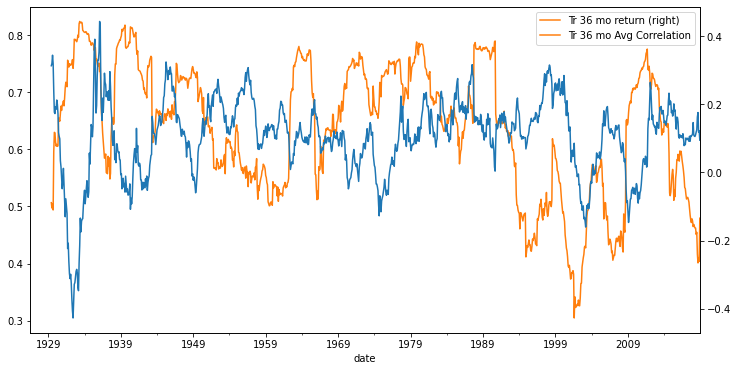

In [19]:
tmi_tr36rets.plot(secondary_y=True, legend=True, label="Tr 36 mo return", figsize=(12,6))
ind_tr36corr.plot(legend=True, label="Tr 36 mo Avg Correlation")

In [20]:
tmi_tr36rets.corr(ind_tr36corr)

-0.28010065062884126

Clearly, these two series are negatively correlated, which explains why diversification fails you when you need it most. When markets fall, correlations rise, making diversification much less valuable.

Instead, we'll look at how to use Insurance to protect the downside.